# S07-demo-05 – Инженерный эксперимент: протокол кластеризации

Это “инженерный” ноутбук: мы собираем **единый протокол эксперимента** для кластеризации и сравниваем несколько кандидатов на одинаковых правилах.

## Что вы освоите
- как построить воспроизводимый протокол для unsupervised-задачи (данные → препроцессинг → кандидаты → сравнение);
- как сравнивать решения по **внутренним метрикам** (silhouette / Davies–Bouldin / Calinski–Harabasz) и понимать ограничения этих метрик;
- как аккуратно работать с DBSCAN (шум `-1`) и не “ломать” метрики;
- как делать краткую сводку: метрики + 2D-визуализация + интерпретация.

## Как работать с ноутбуком
- запускайте ячейки по порядку;
- фиксируйте настройки (`RANDOM_STATE`, одинаковый препроцессинг), иначе сравнение нечестное;
- помните: визуализация помогает *понять*, но не заменяет метрики.

Мы работаем на встроенном датасете **Digits** (64 признака). Истинные метки там есть, но мы используем их **только как учебный контроль** в конце.


## 0. Импорты и базовые настройки

Мы используем:
- `load_digits` как демонстрационный датасет;
- `StandardScaler` (почти обязательно для distance-based методов и метрик);
- `PCA` как опциональный шаг (ускорение/шумоподавление и удобство);
- `KMeans`, `DBSCAN`, `AgglomerativeClustering` как алгоритмы-кандидаты;
- внутренние метрики: silhouette / Davies–Bouldin / Calinski–Harabasz.

Фиксируем `RANDOM_STATE`, чтобы результаты были воспроизводимыми.


In [1]:
# Если вы запускаете ноутбук в "чистом" окружении:
# pip install -U scikit-learn matplotlib numpy

import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score,
    adjusted_rand_score,
    normalized_mutual_info_score,
)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


## 1. Настройки эксперимента

Мы зафиксируем:
- основной датасет: Digits;
- базовый препроцессинг: StandardScaler;
- опциональный этап: PCA до `pca_dim` компонент (часто полезно для ускорения/шумоподавления);
- набор алгоритмов и сетки гиперпараметров.

Важно: это **демо**, а не промышленный AutoML.  
Здесь цель – показать понятный, воспроизводимый протокол.


In [2]:
# Настройки PCA: None (не использовать) или число компонент (например, 30)
pca_dim = 30

# Диапазон K для KMeans
kmeans_ks = list(range(2, 21))

# Сетка для DBSCAN: eps и min_samples
# eps зависит от масштаба данных – после scaling обычно eps ~ 0.5..5 (но это очень примерно).
dbscan_eps = [1.5, 2.0, 2.5, 3.0, 3.5]
dbscan_min_samples = [3, 5, 10]

# Agglomerative: число кластеров и linkage (для sklearn Agglomerative: 'ward' требует euclidean)
agg_ks = list(range(2, 21))
agg_linkages = ["ward", "complete", "average"]

print("Config:")
print(" pca_dim:", pca_dim)
print(" kmeans_ks:", (kmeans_ks[0], "...", kmeans_ks[-1]))
print(" dbscan eps:", dbscan_eps)
print(" dbscan min_samples:", dbscan_min_samples)
print(" agg ks:", (agg_ks[0], "...", agg_ks[-1]))
print(" agg linkages:", agg_linkages)


Config:
 pca_dim: 30
 kmeans_ks: (2, '...', 20)
 dbscan eps: [1.5, 2.0, 2.5, 3.0, 3.5]
 dbscan min_samples: [3, 5, 10]
 agg ks: (2, '...', 20)
 agg linkages: ['ward', 'complete', 'average']


## 2. Данные: Digits

`X` – матрица (n_samples × 64).  
В реальном unsupervised мы бы не имели `y_true`, но здесь оставим как “контроль”.


In [3]:
digits = load_digits()
X = digits.data
y_true = digits.target

print("X.shape:", X.shape, "  y_true classes:", np.unique(y_true))


X.shape: (1797, 64)   y_true classes: [0 1 2 3 4 5 6 7 8 9]


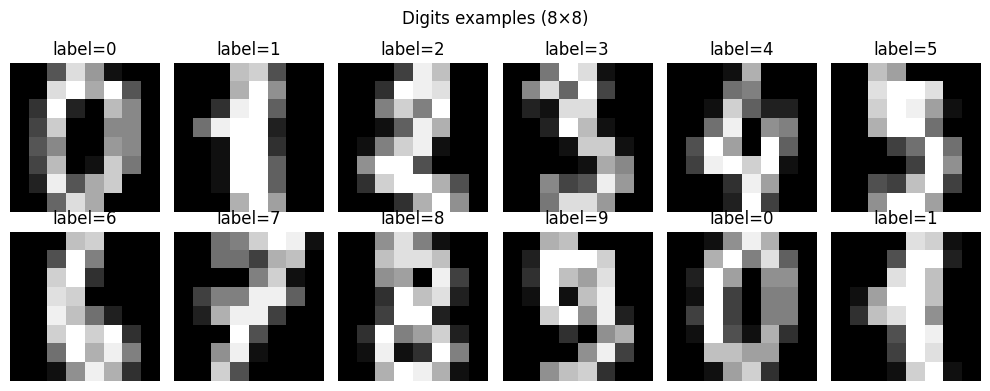

In [4]:
# Покажем несколько примеров, чтобы помнить, что это за данные
fig, axes = plt.subplots(2, 6, figsize=(10, 4))
for ax, idx in zip(axes.ravel(), range(12)):
    ax.imshow(digits.images[idx], cmap="gray")
    ax.set_title(f"label={y_true[idx]}")
    ax.axis("off")
plt.suptitle("Digits examples (8×8)")
plt.tight_layout()
plt.show()


## 3. Препроцессинг: Scaling (+ опционально PCA)

Кластеризация и внутренние метрики часто основаны на расстояниях → scaling почти всегда необходим.

Почему PCA иногда полезна:
- уменьшает шум и размерность;
- ускоряет алгоритмы и визуализацию;
- иногда делает “структуру” более заметной.

Но PCA – не “магия”: это линейное преобразование и оно может упростить слишком сильно.


In [5]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

if pca_dim is None:
    X_feat = X_scaled
    pca_model = None
else:
    pca_model = PCA(n_components=pca_dim, random_state=RANDOM_STATE)
    X_feat = pca_model.fit_transform(X_scaled)

print("X_scaled.shape:", X_scaled.shape)
print("X_feat.shape:", X_feat.shape)


X_scaled.shape: (1797, 64)
X_feat.shape: (1797, 30)


## 4. Функции оценки и визуализации

Мы будем собирать **единый набор метрик** для сравнения подходов.

Внутренние метрики:
- silhouette (выше лучше),
- Davies-Bouldin (ниже лучше),
- Calinski-Harabasz (выше лучше).

Важно: silhouette требует минимум 2 кластера и **не любит шум**.  
Для DBSCAN у нас есть метка -1 (noise). Мы будем:
- считать метрики **по ненулевым точкам** (без шума),
- и дополнительно фиксировать долю шума.


In [6]:
def safe_cluster_metrics(X, labels):
    """Считает метрики; возвращает None, если метрика неприменима."""
    unique = np.unique(labels)
    # Нужно минимум 2 кластера
    if len(unique) < 2:
        return None

    # Нельзя, чтобы все точки были в одном кластере
    if len(unique) == 1:
        return None

    # silhouette требует, чтобы все кластеры имели >1 точки (часто, но не всегда)
    # В sklearn silhouette_score может падать, если какой-то кластер пуст/особый.
    try:
        sil = float(silhouette_score(X, labels))
    except Exception:
        sil = None

    try:
        db = float(davies_bouldin_score(X, labels))
    except Exception:
        db = None

    try:
        ch = float(calinski_harabasz_score(X, labels))
    except Exception:
        ch = None

    return {"silhouette": sil, "davies_bouldin": db, "calinski_harabasz": ch}

def pca_2d_for_plot(X_scaled, random_state=RANDOM_STATE):
    """PCA(2D) именно для визуализации."""
    p = PCA(n_components=2, random_state=random_state)
    return p.fit_transform(X_scaled)

def plot_2d_embedding(emb2d, labels, title):
    plt.figure(figsize=(7, 5))
    plt.scatter(emb2d[:, 0], emb2d[:, 1], c=labels, s=18)
    plt.title(title)
    plt.xlabel("dim-1")
    plt.ylabel("dim-2")
    plt.grid(True, alpha=0.2)
    plt.show()

def summarize_labels(labels):
    unique, counts = np.unique(labels, return_counts=True)
    return dict(zip(unique.tolist(), counts.tolist()))


## 5. Кандидат 1: KMeans (подбор k)

KMeans требует указать `k`. Мы переберём `k` и сравним по внутренним метрикам.


In [7]:
def eval_kmeans_grid(X_feat, ks):
    results = []
    for k in ks:
        try:
            model = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init="auto")
        except TypeError:
            model = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)

        labels = model.fit_predict(X_feat)
        metrics = safe_cluster_metrics(X_feat, labels)

        results.append({
            "algo": "kmeans",
            "params": {"k": k},
            "labels": labels,
            "metrics": metrics,
            "inertia": float(model.inertia_),
            "n_clusters": len(np.unique(labels)),
            "noise_frac": 0.0,
        })
    return results

kmeans_results = eval_kmeans_grid(X_feat, kmeans_ks)
len(kmeans_results), kmeans_results[0]["params"], kmeans_results[-1]["params"]


(19, {'k': 2}, {'k': 20})

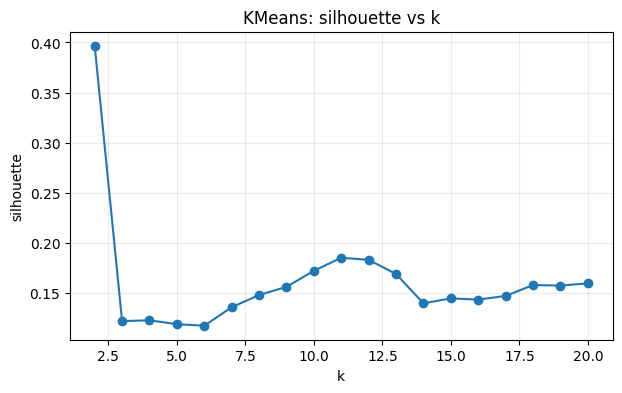

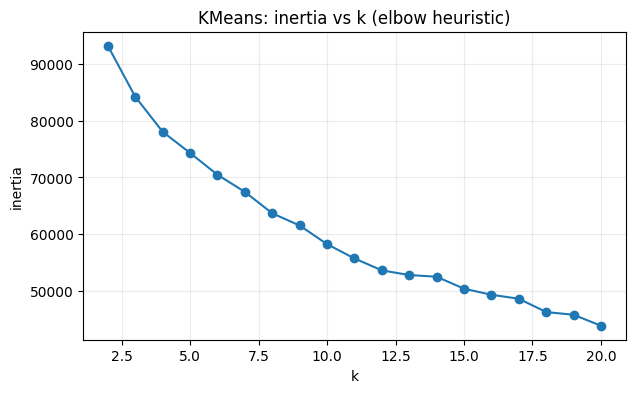

In [8]:
# Быстрый график silhouette по k (если silhouette считалась)
ks = [r["params"]["k"] for r in kmeans_results]
sil = [r["metrics"]["silhouette"] if r["metrics"] else None for r in kmeans_results]

plt.figure(figsize=(7, 4))
plt.plot(ks, sil, marker="o")
plt.title("KMeans: silhouette vs k")
plt.xlabel("k")
plt.ylabel("silhouette")
plt.grid(True, alpha=0.25)
plt.show()

# Инерция (elbow) – как эвристика
inertia = [r["inertia"] for r in kmeans_results]
plt.figure(figsize=(7, 4))
plt.plot(ks, inertia, marker="o")
plt.title("KMeans: inertia vs k (elbow heuristic)")
plt.xlabel("k")
plt.ylabel("inertia")
plt.grid(True, alpha=0.25)
plt.show()


Выберем “лучший” вариант по silhouette (это не единственный критерий, но для демо – удобно).


In [9]:
def pick_best_by_silhouette(results):
    best = None
    best_score = -np.inf
    for r in results:
        m = r["metrics"]
        if m is None:
            continue
        s = m["silhouette"]
        if s is None:
            continue
        if s > best_score:
            best_score = s
            best = r
    return best, best_score

best_kmeans, best_kmeans_s = pick_best_by_silhouette(kmeans_results)
best_kmeans["params"], round(best_kmeans_s, 3)


({'k': 2}, 0.397)

## 6. Кандидат 2: DBSCAN (eps, min_samples)

DBSCAN не требует `k`, но требует параметры плотности:
- `eps` – радиус окрестности,
- `min_samples` – минимальное число точек в окрестности.

Особенность DBSCAN: он может помечать точки как **noise** (`label = -1`).  
Мы фиксируем:
- долю шума,
- количество кластеров (без шума),
- метрики считаем по точкам **без шума** (если их достаточно и кластеров ≥ 2).


In [10]:
def eval_dbscan_grid(X_feat, eps_list, min_samples_list):
    results = []
    n = len(X_feat)

    for eps in eps_list:
        for ms in min_samples_list:
            model = DBSCAN(eps=eps, min_samples=ms)
            labels = model.fit_predict(X_feat)

            noise_frac = float(np.mean(labels == -1))
            # Метрики по non-noise
            mask = labels != -1
            labels_nn = labels[mask]
            X_nn = X_feat[mask]

            # Перенумеруем метки non-noise, чтобы метрики работали корректнее (не обязательно, но аккуратно)
            if len(labels_nn) > 0:
                uniq = np.unique(labels_nn)
                mapping = {u: i for i, u in enumerate(uniq)}
                labels_nn = np.array([mapping[v] for v in labels_nn], dtype=int)

            metrics = None
            n_clusters = 0
            if len(X_nn) >= 10 and len(np.unique(labels_nn)) >= 2:
                metrics = safe_cluster_metrics(X_nn, labels_nn)
                n_clusters = len(np.unique(labels_nn))

            results.append({
                "algo": "dbscan",
                "params": {"eps": float(eps), "min_samples": int(ms)},
                "labels": labels,
                "metrics": metrics,
                "inertia": None,
                "n_clusters": int(n_clusters),
                "noise_frac": float(noise_frac),
                "n_non_noise": int(mask.sum()),
            })
    return results

dbscan_results = eval_dbscan_grid(X_feat, dbscan_eps, dbscan_min_samples)
len(dbscan_results)


15

In [11]:
# Посмотрим, какие варианты вообще дали >=2 кластера (без шума) и посчитали silhouette
valid = [r for r in dbscan_results if r["metrics"] is not None and r["metrics"]["silhouette"] is not None]
print("Valid DBSCAN configs:", len(valid))

# Сортировка по silhouette
valid_sorted = sorted(valid, key=lambda r: r["metrics"]["silhouette"], reverse=True)
for r in valid_sorted[:8]:
    print(r["params"], "sil=", round(r["metrics"]["silhouette"], 3), "noise=", round(r["noise_frac"], 3), "clusters=", r["n_clusters"])


Valid DBSCAN configs: 12
{'eps': 2.0, 'min_samples': 5} sil= 0.717 noise= 0.973 clusters= 3
{'eps': 2.5, 'min_samples': 10} sil= 0.47 noise= 0.933 clusters= 4
{'eps': 2.5, 'min_samples': 5} sil= 0.406 noise= 0.838 clusters= 13
{'eps': 3.0, 'min_samples': 10} sil= 0.399 noise= 0.757 clusters= 9
{'eps': 2.0, 'min_samples': 3} sil= 0.341 noise= 0.93 clusters= 22
{'eps': 1.5, 'min_samples': 3} sil= 0.337 noise= 0.989 clusters= 2
{'eps': 3.0, 'min_samples': 5} sil= 0.276 noise= 0.571 clusters= 27
{'eps': 3.5, 'min_samples': 10} sil= 0.266 noise= 0.459 clusters= 11


In [12]:
best_dbscan = valid_sorted[0] if valid_sorted else None
best_dbscan["params"] if best_dbscan else "No valid config found"


{'eps': 2.0, 'min_samples': 5}

## 7. Кандидат 3: Agglomerative (k, linkage)

AgglomerativeClustering требует `n_clusters` (как KMeans), а также выбор *linkage*.
Мы переберём `k` и `linkage`.


In [13]:
def eval_agglomerative_grid(X_feat, ks, linkages):
    results = []
    for linkage_name in linkages:
        for k in ks:
            try:
                model = AgglomerativeClustering(n_clusters=k, linkage=linkage_name)
                labels = model.fit_predict(X_feat)
            except Exception:
                continue

            metrics = safe_cluster_metrics(X_feat, labels)

            results.append({
                "algo": "agglomerative",
                "params": {"k": int(k), "linkage": linkage_name},
                "labels": labels,
                "metrics": metrics,
                "inertia": None,
                "n_clusters": len(np.unique(labels)),
                "noise_frac": 0.0,
            })
    return results

agg_results = eval_agglomerative_grid(X_feat, agg_ks, agg_linkages)
len(agg_results), agg_results[0]["params"]


(57, {'k': 2, 'linkage': 'ward'})

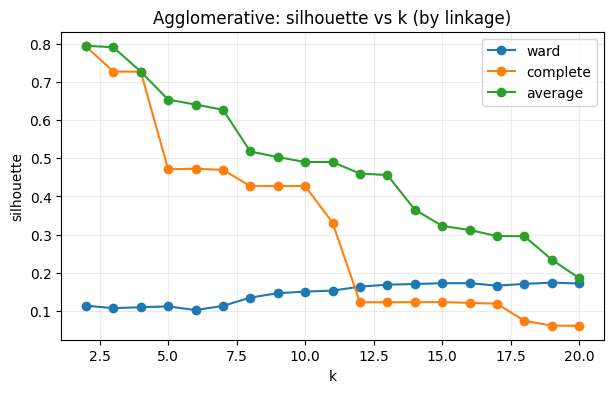

In [14]:
# Силуэт по k для разных linkage (на одном графике – удобно для сравнения)
plt.figure(figsize=(7, 4))

for linkage_name in agg_linkages:
    subset = [r for r in agg_results if r["params"]["linkage"] == linkage_name]
    subset = sorted(subset, key=lambda r: r["params"]["k"])
    ks = [r["params"]["k"] for r in subset]
    sil = [r["metrics"]["silhouette"] if r["metrics"] else None for r in subset]
    plt.plot(ks, sil, marker="o", label=linkage_name)

plt.title("Agglomerative: silhouette vs k (by linkage)")
plt.xlabel("k")
plt.ylabel("silhouette")
plt.grid(True, alpha=0.25)
plt.legend()
plt.show()


In [15]:
best_agg, best_agg_s = pick_best_by_silhouette(agg_results)
best_agg["params"], round(best_agg_s, 3)


({'k': 2, 'linkage': 'average'}, 0.796)

## 8. Сводка кандидатов и выбор

Мы соберём “лучшие” конфигурации каждого семейства по silhouette (для демо).  
В реальной задаче вы бы дополнили:
- устойчивость к seed / подвыборкам,
- интерпретацию кластеров (профили признаков),
- бизнес-ограничения (например, “не больше 8 кластеров”).


In [16]:
def print_result_card(name, result):
    m = result["metrics"] or {}
    print("=" * 72)
    print(f"{name}")
    print("algo:", result["algo"])
    print("params:", result["params"])
    print("n_clusters:", result.get("n_clusters"))
    if result["algo"] == "dbscan":
        print("noise_frac:", round(result.get("noise_frac", 0.0), 3), " non-noise:", result.get("n_non_noise"))
    print("metrics:")
    print("  silhouette:", None if m.get("silhouette") is None else round(m["silhouette"], 3))
    print("  davies_bouldin:", None if m.get("davies_bouldin") is None else round(m["davies_bouldin"], 3))
    print("  calinski_harabasz:", None if m.get("calinski_harabasz") is None else round(m["calinski_harabasz"], 1))
    if result.get("inertia") is not None:
        print("  inertia:", round(result["inertia"], 1))

print_result_card("BEST KMEANS (by silhouette)", best_kmeans)
if best_dbscan is not None:
    print_result_card("BEST DBSCAN (by silhouette among valid)", best_dbscan)
print_result_card("BEST AGGLOMERATIVE (by silhouette)", best_agg)


BEST KMEANS (by silhouette)
algo: kmeans
params: {'k': 2}
n_clusters: 2
metrics:
  silhouette: 0.397
  davies_bouldin: 1.443
  calinski_harabasz: 90.5
  inertia: 93209.2
BEST DBSCAN (by silhouette among valid)
algo: dbscan
params: {'eps': 2.0, 'min_samples': 5}
n_clusters: 3
noise_frac: 0.973  non-noise: 48
metrics:
  silhouette: 0.717
  davies_bouldin: 0.39
  calinski_harabasz: 132.4
BEST AGGLOMERATIVE (by silhouette)
algo: agglomerative
params: {'k': 2, 'linkage': 'average'}
n_clusters: 2
metrics:
  silhouette: 0.796
  davies_bouldin: 0.145
  calinski_harabasz: 41.5


## 9. Визуализация выбранных решений в 2D

Важно: 2D-визуализация – **инструмент понимания**, а не метрика качества.

Мы построим PCA(2D) на **X_scaled** (до PCA в feature space), и раскрасим точки по разным решениям.


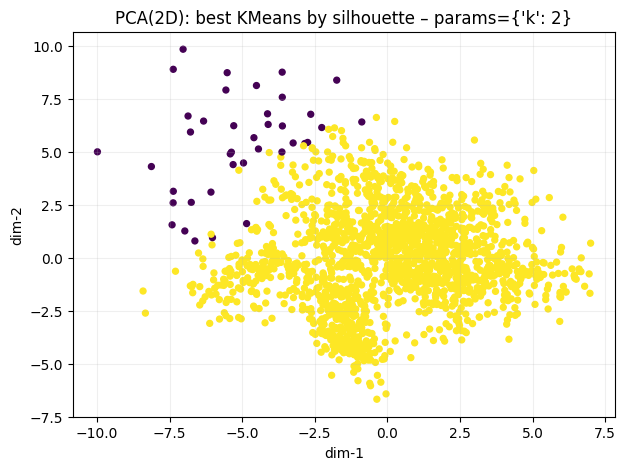

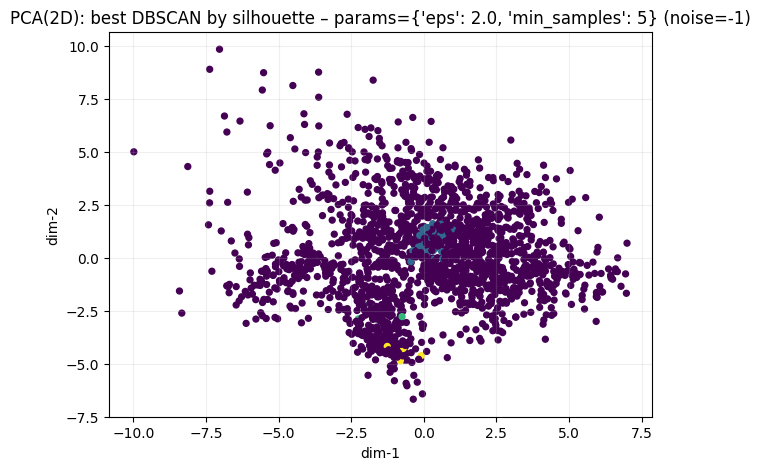

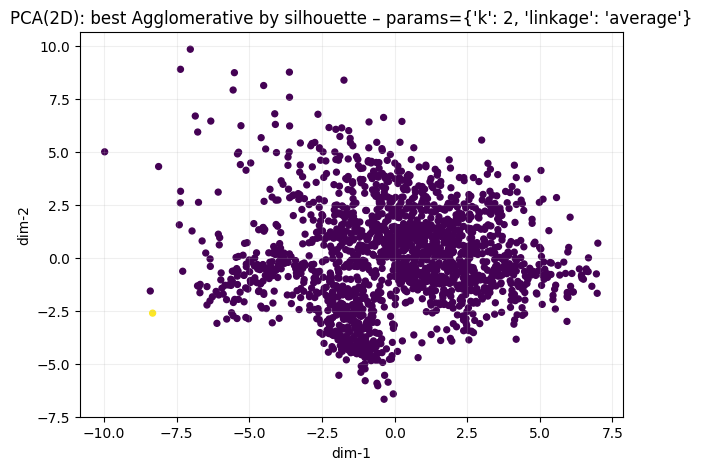

In [17]:
X_plot2d = pca_2d_for_plot(X_scaled, random_state=RANDOM_STATE)

# KMeans best
plot_2d_embedding(
    X_plot2d, best_kmeans["labels"],
    title=f"PCA(2D): best KMeans by silhouette – params={best_kmeans['params']}"
)

# DBSCAN best (if exists)
if best_dbscan is not None:
    plot_2d_embedding(
        X_plot2d, best_dbscan["labels"],
        title=f"PCA(2D): best DBSCAN by silhouette – params={best_dbscan['params']} (noise=-1)"
    )

# Agglomerative best
plot_2d_embedding(
    X_plot2d, best_agg["labels"],
    title=f"PCA(2D): best Agglomerative by silhouette – params={best_agg['params']}"
)


## 10. Учебный контроль: внешние метрики (когда есть истинные метки)

В реальности истинных меток часто нет, но на Digits они есть.  
Оценим:
- **ARI**
- **NMI**

Важно: сопоставление “кластеров” и “классов” не обязано быть 1-в-1, поэтому эти числа – просто ориентир.


In [18]:
def external_metrics(y_true, labels):
    return {
        "ARI": float(adjusted_rand_score(y_true, labels)),
        "NMI": float(normalized_mutual_info_score(y_true, labels)),
    }

print("=" * 72)
print("External metrics (bonus):")
print("KMeans best:", {k: round(v, 3) for k, v in external_metrics(y_true, best_kmeans["labels"]).items()})
if best_dbscan is not None:
    # Для DBSCAN есть шум -1; внешние метрики можно считать "как есть", но это не идеально.
    print("DBSCAN best:", {k: round(v, 3) for k, v in external_metrics(y_true, best_dbscan["labels"]).items()})
print("Agglom best:", {k: round(v, 3) for k, v in external_metrics(y_true, best_agg["labels"]).items()})


External metrics (bonus):
KMeans best: {'ARI': 0.001, 'NMI': 0.024}
DBSCAN best: {'ARI': 0.001, 'NMI': 0.051}
Agglom best: {'ARI': -0.0, 'NMI': 0.001}


## 11. Мини-рефлексия: что бы вы сделали в реальном проекте?

Подумайте (и при желании ответьте себе в заметках):

- Какие признаки вы бы добавили/исключили?
- Нужно ли кодирование категориальных признаков?
- Какие ограничения на количество кластеров заданы бизнесом?
- Есть ли смысл в UMAP вместо t-SNE/PCA для визуализации?
- Как вы проверите устойчивость результата (подвыборки, noise, seed)?


## Короткие выводы

- В unsupervised-эксперименте “честность” достигается не train/test, а **протоколом сравнения**:
  препроцессинг → кандидаты → подбор параметров → метрики → визуализация → интерпретация.
- Внутренние метрики нужны, чтобы **сравнивать** решения, но не дают “истины”.
- 2D-карты (PCA) помогают понять структуру, но не должны подменять собой оценку.
